In [4]:
import os
import json
import numpy as np
import math
import requests
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, hamming_loss, classification_report, multilabel_confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import EfficientNetB0
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dense, MaxPooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
NUM_CLASSES = 8
NUM_EPOCH = 100
INPUT_SHAPE = (224, 224, 3)
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
LABELS = [
    "shirt, blouse",
    "top, t-shirt, sweatshirt",
    "jacket",
    "pants",
    "skirt",
    "dress",
    "shoe",
    "bag, wallet"
]

In [6]:
# Base Path
DIR_BASE = "/kaggle/input/8-labels-cloth-classification"
OUTPUT_DIR = "/kaggle/working"
cnn_model_path = os.path.join(OUTPUT_DIR, "cnn_best.h5")
efficient_model_path = os.path.join(OUTPUT_DIR, "efficientB0.h5")

In [7]:
# Dataset paths
img_folder = os.path.join(DIR_BASE, "imgs")
train_annotations = os.path.join(DIR_BASE, "train/data.json")
val_annotations = os.path.join(DIR_BASE, "val/data.json")
test_annotations = os.path.join(DIR_BASE, "test/data.json")

In [8]:
def load_dataset(img_folder, annotation_file, input_size=IMG_SIZE):
    print(annotation_file)
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)

    images = []
    labels = []

    for ann in tqdm(annotations):
        img_path = os.path.join(img_folder, ann["imgPath"])
        label = np.array(ann["labels"])
        bbox_info = ann.get("bbox", [])

        # Load image
        img = load_img(img_path, target_size=input_size)
        img_array = img_to_array(img) / 255.0

        images.append(img_array)
        labels.append(label)

    return np.array(images), np.array(labels)

In [9]:
class ImageDataGenerator(Sequence):
    def __init__(self, img_folder, annotation_file, batch_size=BATCH_SIZE, input_size=IMG_SIZE, shuffle=True):
        self.img_folder = img_folder
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        # Load annotations
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
            
        # Validate annotations
        if not self.annotations or not isinstance(self.annotations, list):
            raise ValueError("Annotations must be a non-empty list")
            
        self.indexes = np.arange(len(self.annotations))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
        print(f"Total images: {len(self.annotations)}")

    def __len__(self):
        return int(np.ceil(len(self.annotations) / self.batch_size))

    def __getitem__(self, idx):
        # Get indexes for current batch
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.annotations))
        batch_indexes = self.indexes[start_idx:end_idx]
        
        # Initialize batch arrays
        batch_size = len(batch_indexes)
        batch_images = np.zeros((batch_size,) + self.input_size + (3,), dtype=np.float32)
        batch_labels = []
        
        # Load images and labels
        for i, idx in enumerate(batch_indexes):
            ann = self.annotations[idx]
            
            # Load and process image
            img_path = os.path.join(self.img_folder, ann["imgPath"])
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image not found: {img_path}")
                
            img = load_img(img_path, target_size=self.input_size)
            img_array = img_to_array(img) / 255.0
            batch_images[i] = img_array
            
            # Get label
            if "labels" not in ann:
                raise KeyError(f"Labels not found in annotation for image: {ann['imgPath']}")
            batch_labels.append(ann["labels"])
            
        batch_labels = np.array(batch_labels, dtype=np.float32)
        
        return batch_images, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [10]:
def custom_accuracy(y_true, y_pred, threshold=0.5):
    """
    Tính độ chính xác tùy chỉnh (custom accuracy) cho bài toán đa nhãn với ngưỡng có thể điều chỉnh.
    
    Args:
        y_true: Tensor của nhãn thực tế (ground truth labels).
        y_pred: Tensor của dự đoán xác suất từ mô hình.
        threshold: Ngưỡng để chuyển xác suất thành nhãn nhị phân (mặc định: 0.5).
    
    Returns:
        Tensor: Độ chính xác trung bình trên tất cả các nhãn.
    """
    # Chuyển y_true về dạng float để tính toán
    # Áp dụng ngưỡng cho predictions để chuyển thành nhãn nhị phân
    y_true = K.cast(y_true, K.floatx())
    y_pred = K.cast(y_pred >= threshold, K.floatx())  
    
    # Tính đúng sai từng nhãn
    correct = K.cast(K.equal(y_true, y_pred), K.floatx())
    
    # Tính trung bình chính xác của từng nhãn và sau đó lấy trung bình trên tất cả các nhãn
    label_accuracies = K.mean(correct, axis=0)  # Chính xác trên từng nhãn
    overall_accuracy = K.mean(label_accuracies)  # Trung bình trên tất cả nhãn
    
    return overall_accuracy


In [11]:
def custom_hamming_loss(y_true, y_pred, threshold=0.5):
    """
    Tính Hamming Loss cho bài toán phân loại đa nhãn.
    Hamming Loss là tỷ lệ nhãn bị dự đoán sai trên tổng số nhãn.
    
    Args:
        y_true: Tensor của nhãn thực tế
        y_pred: Tensor của dự đoán xác suất
        threshold: Ngưỡng để chuyển xác suất thành nhãn
    
    Returns:
        Tensor: Hamming Loss
    """
    y_pred = K.cast(y_pred >= threshold, K.dtype(y_true))
    y_true = K.cast(y_true, K.dtype(y_pred))
    
    return K.mean(K.cast(K.not_equal(y_true, y_pred), K.floatx()))

def custom_exact_match_ratio(y_true, y_pred, threshold=0.5):
    """
    Tính tỷ lệ các mẫu có tất cả các nhãn được dự đoán đúng.
    
    Args:
        y_true: Tensor của nhãn thực tế
        y_pred: Tensor của dự đoán xác suất
        threshold: Ngưỡng để chuyển xác suất thành nhãn
    
    Returns:
        Tensor: Tỷ lệ exact match
    """
    y_pred = K.cast(y_pred >= threshold, K.dtype(y_true))
    y_true = K.cast(y_true, K.dtype(y_pred))
    
    # Kiểm tra xem tất cả các nhãn có đúng không
    all_correct = K.all(K.equal(y_true, y_pred), axis=-1)
    return K.mean(K.cast(all_correct, K.floatx()))

In [18]:
# Initialize generators
train_generator = ImageDataGenerator(
    img_folder=img_folder,
    annotation_file=train_annotations,
    batch_size=BATCH_SIZE
)

val_generator = ImageDataGenerator(
    img_folder=img_folder,
    annotation_file=val_annotations,
    batch_size=BATCH_SIZE
)

Total images: 35290
Total images: 4411


In [13]:
X_test, y_test = load_dataset(img_folder, test_annotations)

/kaggle/input/8-labels-cloth-classification/test/data.json


100%|██████████| 4412/4412 [00:45<00:00, 96.20it/s] 


In [21]:
# Build base model
base_model = EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')

# Add classification head
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Create model
efficient_model = Model(inputs=base_model.input, outputs=output)

# Compile model
efficient_model.compile(
    optimizer='adam', 
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  
    metrics=[custom_accuracy, custom_hamming_loss, custom_exact_match_ratio]
)

# Summary
efficient_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,059,819 (15.49 MB)

 Trainable params: 4,017,796 (15.33 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [22]:
# Combine callbacks into a list
callbacks_efficient = [
        EarlyStopping(
        monitor='val_loss',           # Metric to monitor
        patience=5,                   # Number of epochs with no improvement after which training will stop
        mode='min',                   # Training will stop when monitored metric stops decreasing
        restore_best_weights=True,    # Restore model weights from the epoch with the best value of monitored quantity
        verbose=1                     # Print message when early stopping is triggered
    ),
        ModelCheckpoint(
        f'{OUTPUT_DIR}/best_efficient_model.keras',    # Path to save the best model
        monitor='val_loss',           # Metric to monitor 
        save_best_only=True,         # Only save when monitored metric improves
        mode='min',                   # Save when monitored metric is minimized
        verbose=1                     # Print message for each save
    )
]

In [23]:
# Train the model - đã bỏ workers và use_multiprocessing
history_efficient = efficient_model.fit(
    train_generator,
    epochs=4,
    validation_data=val_generator,
    callbacks=callbacks_efficient,
    verbose=1
)

Epoch 1/4
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - custom_accuracy: 0.8519 - custom_exact_match_ratio: 0.3918 - custom_hamming_loss: 0.1481 - loss: 0.3325
Epoch 1: val_loss improved from inf to 0.63298, saving model to /kaggle/working/best_efficient_model.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - custom_accuracy: 0.8520 - custom_exact_match_ratio: 0.3920 - custom_hamming_loss: 0.1480 - loss: 0.3323 - val_custom_accuracy: 0.6530 - val_custom_exact_match_ratio: 0.0436 - val_custom_hamming_loss: 0.3470 - val_loss: 0.6330
Epoch 2/4
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - custom_accuracy: 0.9151 - custom_exact_match_ratio: 0.5821 - custom_hamming_loss: 0.0849 - loss: 0.2063
Epoch 2: val_loss did not improve from 0.63298
276/276 ━━━━━━━━━━━━━━━━━━━━ 226s 798ms/step - custom_accuracy: 0.9151 - custom_exact_match_ratio: 0.5821 - custom_hamming_loss: 0.0849 - loss: 0.2063 - val_custom_accuracy: 0.7775 - val_custom_exact_match_ratio: 0.2245 - val_custom_hamming_loss: 0.2225 - val_l

In [24]:
# Save the model
efficient_model.save("b0_v2.h5")

In [25]:
efficient_model.save_weights("eff_model_weights2.weights.h5")

In [26]:
efficient_model.save('testSave2.h5', include_optimizer=True)

In [27]:
loaded_efficient_model = load_model("/kaggle/working/testSave2.h5")

In [43]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [29]:
# Hàm dự đoán
def predict_image(img_array, model):
    img_resized = cv2.resize(img_array, (224, 224))  # Resize để phù hợp với input của model
    img_array = img_resized / 255.0  # Chuẩn hóa giá trị pixel
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)[0]
    predicted_labels = [i for i, prob in enumerate(predictions) if prob > 0.5]
    print(predictions)

    # Map chỉ số với tên class
    predicted_class_names = [LABELS[i] for i in predicted_labels]

    return predicted_class_names

In [30]:
def load_image_from_url(url):
    """
    Tải ảnh từ URL hoặc từ đường dẫn file local.

    Args:
        url (str): URL hoặc đường dẫn file local của ảnh.

    Returns:
        img (numpy.ndarray): Ảnh được tải dưới dạng mảng numpy.
    """
    if os.path.isfile(url):  # Kiểm tra nếu là đường dẫn file local
        return cv2.imread(url, cv2.IMREAD_COLOR)
    else:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            img_array = np.asarray(bytearray(response.content), dtype=np.uint8)
            return cv2.imdecode(img_array, cv2.IMREAD_COLOR)
        else:
            raise ValueError(f"Failed to fetch image from {url}")

In [31]:
# Ghi nhãn lên ảnh
def annotate_image_with_labels(img, predicted_class_names):
    y_offset = 30  # Vị trí ban đầu của nhãn
    for label in predicted_class_names:
        cv2.putText(
            img, label, (10, y_offset),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1,
            color=(0, 255, 0),  # Màu xanh lá
            thickness=2
        )
        y_offset += 40  # Tăng vị trí cho nhãn tiếp theo
    return img

In [32]:
def process_and_display_images(urls, model):
    """
    Dự đoán và hiển thị kết quả dựa trên các URL hình ảnh.

    Args:
        urls (list): Danh sách các URL hình ảnh.
        model: Mô hình dùng để dự đoán nhãn hình ảnh.
        categories (list): Danh sách các danh mục để phân loại hình ảnh.
    """
    for url in urls:
        try:
            # Tải ảnh từ URL
            img = load_image_from_url(url)

            # Dự đoán nhãn
            predicted_class_names = predict_image(img, model)

            # Ghi nhãn lên ảnh
            annotated_img = annotate_image_with_labels(img, predicted_class_names)

            # Chuyển đổi màu ảnh từ BGR sang RGB để hiển thị với Matplotlib
            annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

            # Hiển thị ảnh
            plt.figure(figsize=(10, 8))
            plt.imshow(annotated_img_rgb)
            plt.axis('off')
            plt.title("Predicted Labels: " + ', '.join([('"' + className + '"') for className in predicted_class_names]))
            plt.show()

        except Exception as e:
            print(f"Error processing image from URL {url}: {e}")

In [37]:
loaded_efficient_model = load_model("/kaggle/working/testSave2.h5")

In [38]:
# Danh sách URL
urls = [
"/kaggle/input/8-labels-cloth-classification/imgs/0002f5a0ebc162ecfb73e2c91e3b8f62.jpg",
"/kaggle/input/8-labels-cloth-classification/imgs/00d4ade9db192bb8804e44a86b203a5c.jpg",
"/kaggle/input/8-labels-cloth-classification/imgs/01a4d4feb172d8120b753d66d6e5b9e8.jpg",
"/kaggle/input/8-labels-cloth-classification/sample/test1.jpg",
"/kaggle/input/8-labels-cloth-classification/sample/test4.jpg",
"https://i5.walmartimages.com/seo/George-Men-s-Premium-Straight-Fit-Khaki-Pants_f659d317-de24-4b92-bf8d-05e1223a2bf7.c2637e94c3c2c3e9e36485c039e3d0e2.jpeg",
"https://britishretro.co.uk/wp-content/uploads/2023/08/006-red-tartan-50s-full-circle-skirt.jpg",
"https://factorie.com.au/on/demandware.static/-/Sites-catalog-master-factorie/default/dwc47daf5b/5297749/5297749-02-2.jpg",
"https://vulcano.sgp1.digitaloceanspaces.com/media/17830/ao-jacket-3003b-vulcano01.webp",
"https://images.pexels.com/photos/29859973/pexels-photo-29859973/free-photo-of-two-men-shopping-in-urban-mall-setting.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2",
]


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[6.5851938e-03 4.4602778e-02 5.2941297e-03 4.2104090e-04 1.0073180e-03
 7.5239027e-01 1.0551537e-03 1.5278595e-03]


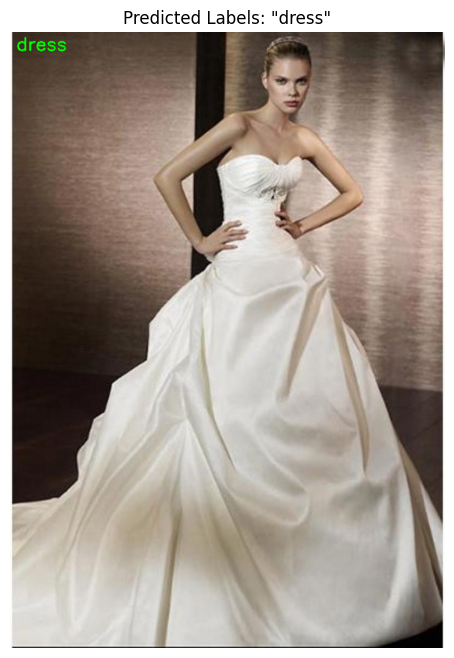

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[5.9648190e-02 3.4689206e-01 2.9863400e-02 4.9802974e-01 3.0474606e-04
 5.0471663e-03 6.0688815e-04 8.7669067e-04]


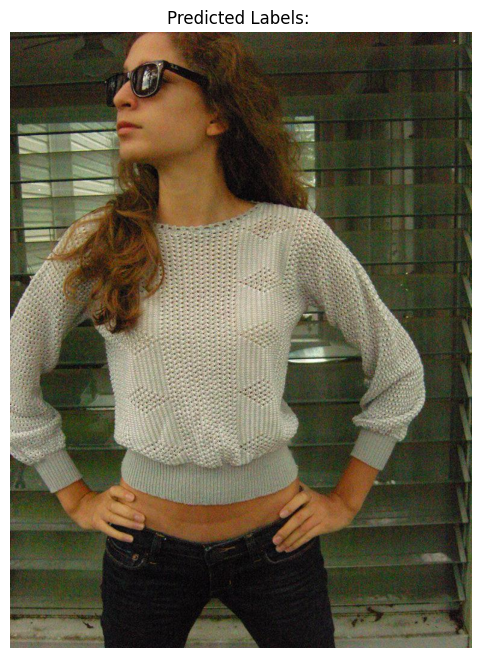

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[1.4812619e-04 9.9629825e-01 7.5996313e-06 7.2599496e-03 1.5717933e-04
 9.7138120e-04 1.6739961e-03 9.5511472e-04]


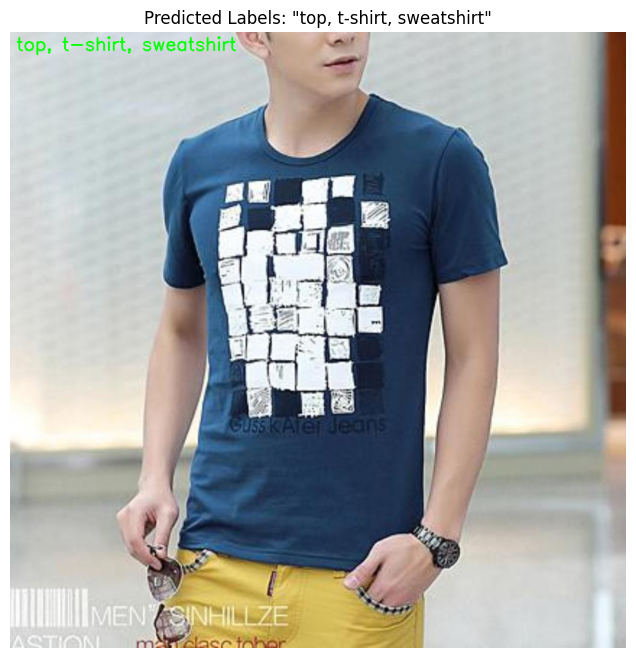

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[4.1127154e-01 5.4083705e-01 8.6633049e-02 9.2490357e-01 1.1433839e-04
 5.1368639e-04 2.4439610e-04 8.7688700e-04]


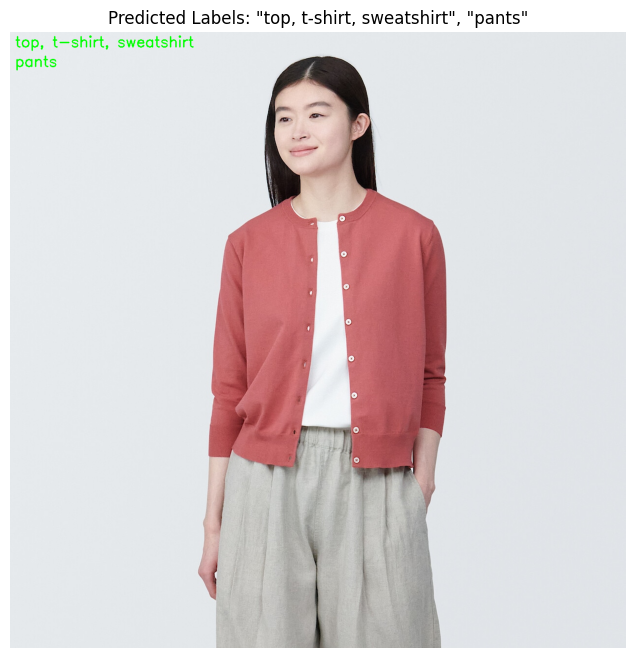

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[7.9650842e-03 7.4354434e-01 4.8776087e-03 1.1817991e-03 3.0382322e-03
 3.7558522e-02 2.7445416e-04 3.2509307e-03]


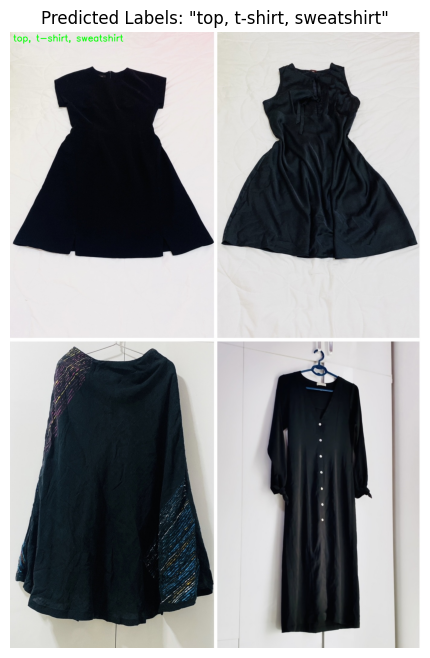

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[7.2276101e-02 2.7666292e-01 7.4891858e-02 9.5250589e-01 8.9156987e-05
 8.7272417e-04 9.1045016e-01 2.4890885e-04]


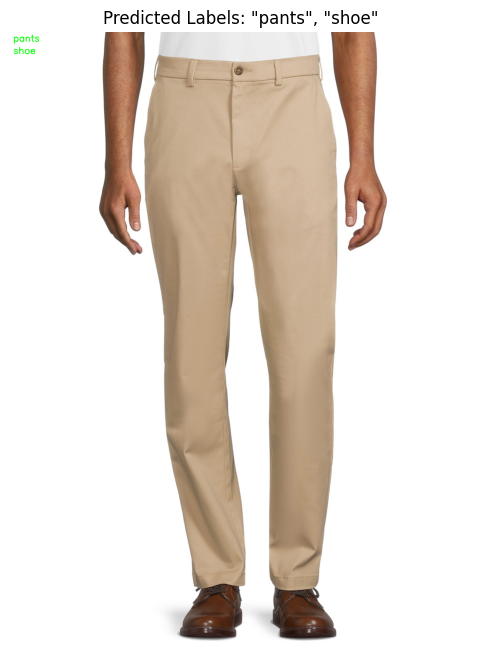

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[1.0935471e-03 8.7063044e-01 5.9277803e-04 1.0604485e-02 9.5433855e-01
 6.5276541e-02 9.9820256e-01 1.3134955e-02]


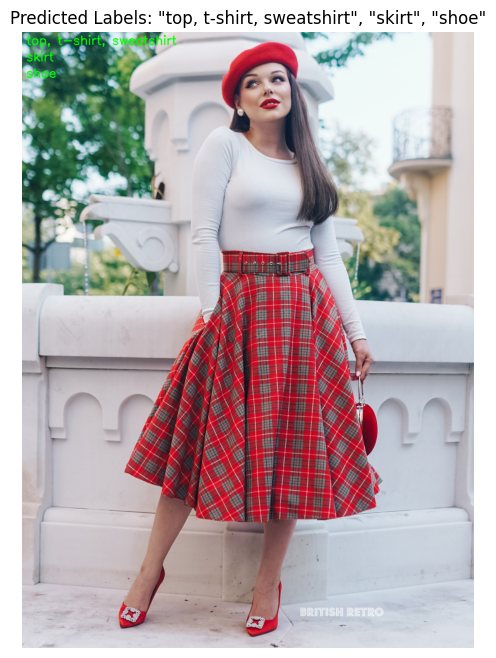

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[2.5658825e-02 4.3861726e-01 9.4756240e-01 1.5396073e-01 4.7536287e-06
 3.4466317e-05 6.6238033e-05 8.6989668e-05]


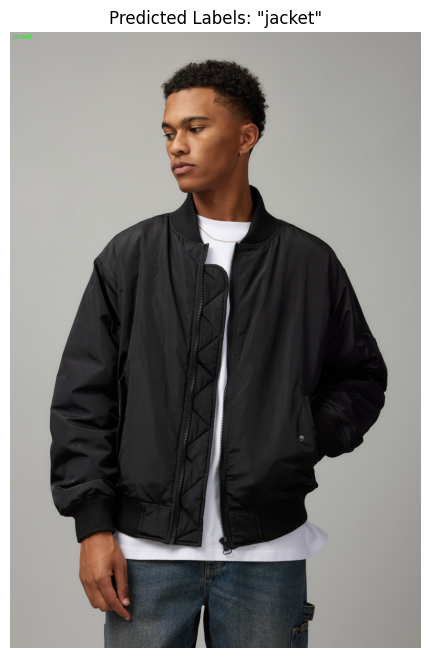

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[6.2473219e-02 7.6380336e-01 8.6970001e-01 8.5980231e-01 2.0432066e-05
 1.3280846e-04 1.5106915e-04 5.8822419e-02]


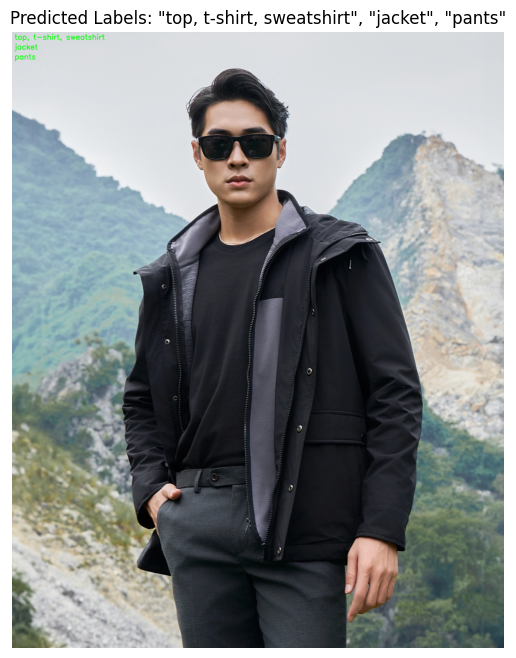

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.0525679  0.5658764  0.01807391 0.79761094 0.00476921 0.00928519
 0.23892002 0.85294235]


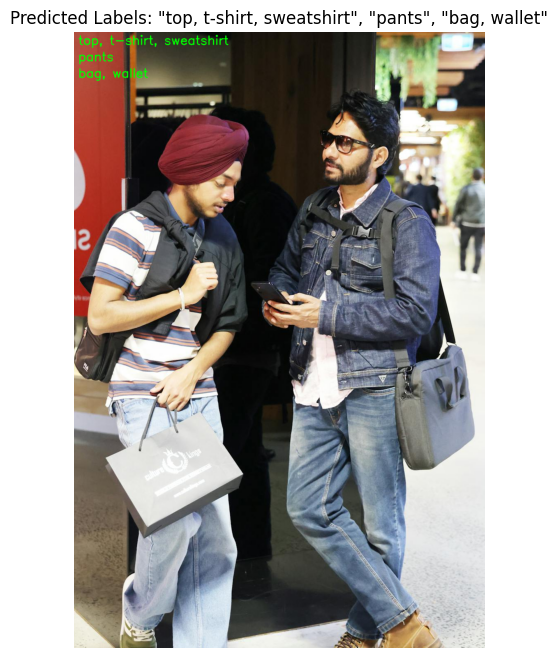

In [39]:
process_and_display_images(urls, loaded_efficient_model)